# K-Means Clustering with OpenMP and MPI

### Implement the k-means clustering algorithm in OpenMP/MPI, trying to maximize the performance (reduce the execution time) by carefully exploiting the resources within one computing node with multiple processing cores (OpenMP) and across computing nodes (MPI).

Optional: implement the same algorithm in Apache Flink and compare the performance of the two implementations (processing time and scalability) under various workloads.

-------------------------------------------------------------------------------------------------------------------------

In [1]:
import csv
import random
import sys

import numpy
import os  # We need this module
import matplotlib.pyplot as plt
import seaborn as sns;
from sklearn.datasets.samples_generator import make_blobs
sns.set()  # for plot styling

#Samples
N_SAMPLES = 100000

# Get path of the current dir, then use it to create paths:
CURRENT_DIR = os.path.dirname("__file__")
file_path = os.path.join(CURRENT_DIR, 'dataset_display/dataset.csv')
initial_dataset_path = os.path.join(CURRENT_DIR, 'dataset_display/initialdataset.csv')
initial_centroids_path = os.path.join(CURRENT_DIR, 'dataset_display/initialcentroids.csv')
new_dataset_path = os.path.join(CURRENT_DIR, 'dataset_display/newdataset.csv')
new_centroids_path = os.path.join(CURRENT_DIR, 'dataset_display/newcentroids.csv')
objfun_path = os.path.join(CURRENT_DIR, 'dataset_display/objfun.csv')
exectimes_path = os.path.join(CURRENT_DIR, 'dataset_display/exectimes.csv')

fig_width = 12
fig_height = 10

# Initial Dataset

## Display the points in the Initial Dataset:

We have a Dataset of 100000 points, randomly generated by a custom Python script. These points are already somehow divided in clusters so that we can more easily test the K-Means Clustering algorithm.

In [2]:
print('X,Y')
with open(initial_dataset_path) as csvfile:
    reader = csv.DictReader(csvfile)
    for i,row in enumerate(reader):
        print(row['X'], row['Y'])
        if(i >= 10):
            break
            
print("Total points: %s" % format(N_SAMPLES,'d'))

X,Y
4.762006 -7.700549
4.490764 -8.202433
-1.384802 2.850730
-1.411994 -6.885759
0.045029 1.578344
-7.419469 9.258043
-6.915910 9.343622
-7.663262 8.672174
-2.618907 -6.364270
-1.369107 -8.103168
-7.965163 9.759896
Total points: 100000


## And now we plot the initial dataset:

By plotting the Dataset, we can see that is indeed form by 4 clusters easily observable. We'll later test the K-Means Clustering algorithm and see if it can also individuate the clusters.

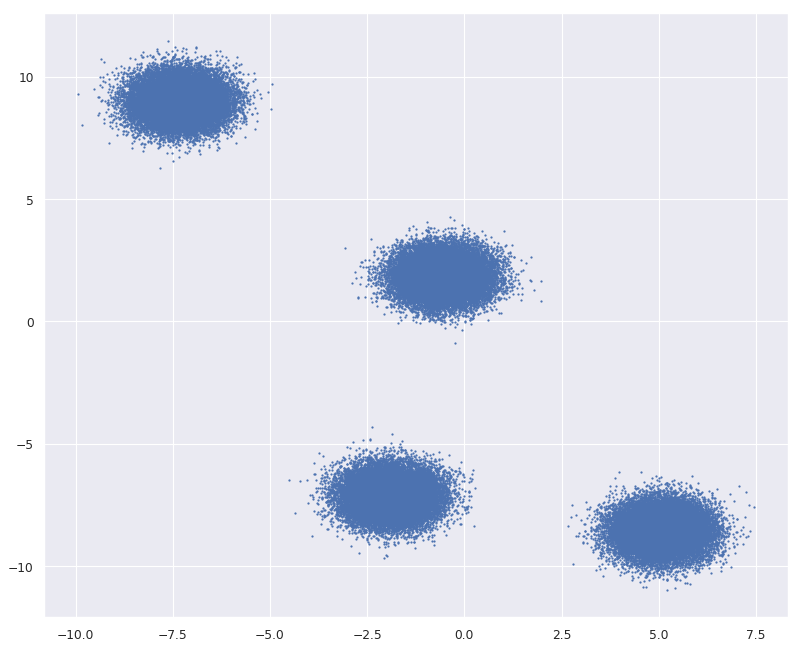

In [3]:
x = numpy.zeros(N_SAMPLES)
y = numpy.zeros(N_SAMPLES)

#Read the dataset from the CVS file
with open(initial_dataset_path) as csvfile:
    reader = csv.DictReader(csvfile)
    i = 0
    for row in reader:
        x[i] = row['X']
        y[i] = row['Y']
        #print(x[i], y[i])
        i=i+1

#Plot the read dataset
plt.figure(figsize=(fig_width, fig_height), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(x[:], y[:], s=1)
plt.show()

## Initial Centroids

The Initial Centroids are randomply placed at runtime, however a centroids will be recreated if it is too close to another centroid. The initial placing of the centroids is of fundamental importance to the result of the K-Means Clustering algorithm execution on a given dataset. Lets print the centroids: 

In [4]:
print('Cluster,X,Y')
centroids = 0
with open(initial_centroids_path) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        print(centroids, row['X'], row['Y'])
        centroids = centroids + 1
print("Total centroids: %d" % centroids)

Cluster,X,Y
0 4.066931 8.023582
1 -1.933069 -5.976418
2 1.066931 5.023582
3 5.066931 0.023582
Total centroids: 4


And now we plot them:

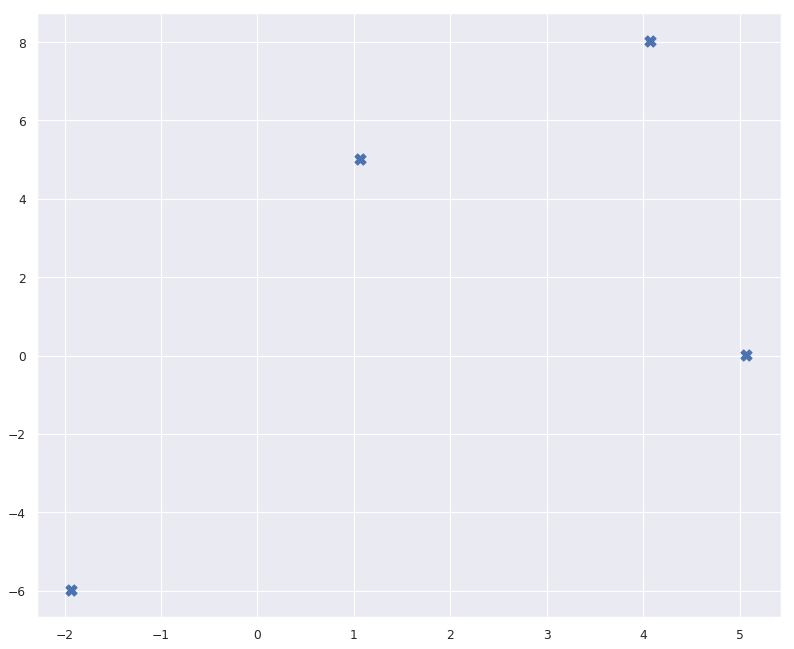

In [5]:
x = numpy.zeros(centroids)
y = numpy.zeros(centroids)

#Read the dataset from the CVS file
with open(initial_centroids_path) as csvfile:
    reader = csv.DictReader(csvfile)
    i = 0
    for row in reader:
        x[i] = row['X']
        y[i] = row['Y']
        #print(x[i], y[i])
        i=i+1

#Plot the read dataset
plt.figure(figsize=(fig_width, fig_height), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(x[:], y[:], marker="X", s=100)
plt.show()

# Plotting both Dataset and Centroids

 We've run the K-Means Clustering Algorithm on the initial dataset and got new centroids each associated to a cluster. So we now plot the resulting clusters separated by a random color and their centroids:

In [6]:
def random_color():
    return numpy.random.rand(3,)

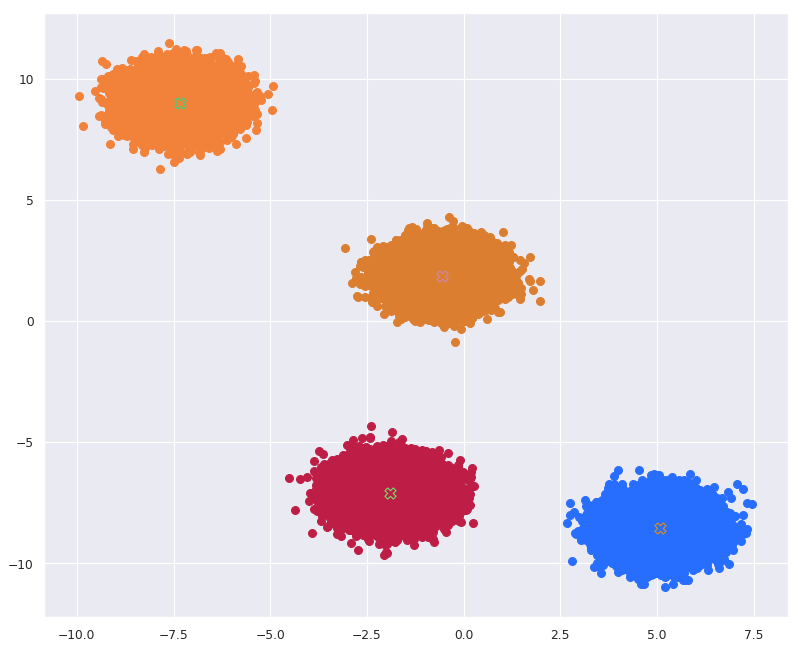

In [7]:
x = numpy.zeros(N_SAMPLES)
y = numpy.zeros(N_SAMPLES)
c = numpy.zeros(N_SAMPLES)
cx = list()
cy = list()

plt.figure(figsize=(fig_width, fig_height), dpi= 80, facecolor='w', edgecolor='k')

# Read the new centroids from the CVS file
with open(new_centroids_path) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        cx.append(float(row['X']))
        cy.append(float(row['Y']))

# Read the new dataset from the CVS file
with open(new_dataset_path) as csvfile:
    reader = csv.DictReader(csvfile)
    i = 0
    for row in reader:
        x[i] = row['X']
        y[i] = row['Y']
        c[i] = row['Cluster']
        # print(x[i], y[i])
        i = i + 1

minK = c.min()
maxK = c.max()
k = (int)(maxK - minK + 1)

# plot the points for each cluster with a different color
for i in range(k):
    x2 = list()
    y2 = list()

    for j in range(N_SAMPLES):
        if c[j] == i:
            x2.append(x[j])
            y2.append(y[j])

    # Plot the read dataset
    color1 = random_color()
    color2 = random_color()
    plt.scatter(x2[:], y2[:], c=color1, s=50)
    plt.scatter(cx[i], cy[i], c=color1, marker="X", edgecolor=color2, s=100)
plt.show()

## Running Modes: Normal, OpenMP, MPI

The program written in C actually executes three different versions of the K-Means Clustering Algorithm. They run sequentially one at a time, but they use the same initial dataset and the same random pair of initial centroids. The initial position of the centroids is of vital importance to the result of the execution so is important that all three versions use the same set of centroids so that we can have a meaningful comparison in performance.
All three versions will produce the same result and same objective function value, but they will have different execution times. We've set the maximum number of cores for the OpenMP verision (4 on this PC), and 4 parallel processes for the MPI Version. As expected the OpenMP and MPI version perform much better that the sequential version, here are the result on this dataset:

In [11]:
print('Execution Times:\n')
t = numpy.zeros(3)
with open(exectimes_path) as csvfile:
    reader = csv.DictReader(csvfile)
    for i,row in enumerate(reader):
        t[i] = row['Time']
            
print('Normal Execution --> ' + str(t[0]*1000) + 'ms')
print('OpenMP Execution --> ' + str(t[1]*1000) + 'ms')
print('MPI Execution    --> ' + str(t[2]*1000) + 'ms')

Execution Times:


Normal Execution --> 117.774ms
OpenMP Execution --> 35.004ms
MPI Execution    --> 60.367999999999995ms


While the value of the Objective Function is:

In [16]:
objfun = numpy.zeros(3)
with open(objfun_path) as csvfile:
    reader = csv.DictReader(csvfile)
    for i,row in enumerate(reader):
        objfun[i] = row['ObjFun']
            
print('ObjectiveFunction value --> ' + str(objfun[0]))

ObjectiveFunction value --> 71883.664062


# Results